In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from sklearn import metrics
from copy import deepcopy
from scipy.spatial.distance import hamming
from time import perf_counter
import csv
from torch.nn.modules import activation
import random
import pandas


from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'ExcitationBP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
#dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
#dataset = GINDataset('MUTAG', self_loop=False)


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [7]:
print("Number of Graphs: ", len(dataset))
print("Number of Node Features: ", dataset.num_node_features)
print("Number of Edge Features: ", dataset.num_edge_features)
#print("Number of Node Features: ", dataset.num_node_attributes)
#print("Number of Node Features: ", dataset.num_edge_attributes)
print("Number of Classes: ", dataset.num_classes)
count=0
for i in range(len(dataset)):
    count = count + len(dataset[i].edge_index[0])
print("Number of Edges: ", count)
data = dataset[0]
print(data)
#print(dataset.labels)

Number of Graphs:  188
Number of Node Features:  7
Number of Edge Features:  4
Number of Classes:  2
Number of Edges:  7442
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [8]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [9]:
torch.manual_seed(123456)

#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=100, shuffle=True)
#train_dataset = dataset[:150]
#test_dataset = dataset[150:]

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [10]:
print("Number of Training Graphs: ", len(train_dataset))
print("Number of Test Graphs: ", len(test_dataset))

count=0
for i in range(len(train_dataset)):
    count = count + len(train_dataset[i].edge_index[0])
print("Number of Edges in TrainingSet: ", count)
count=0
for i in range(len(test_dataset)):
    count = count + len(test_dataset[i].edge_index[0])
print("Number of Edges in TestSet: ", count)

Number of Training Graphs:  150
Number of Test Graphs:  38
Number of Edges in TrainingSet:  6064
Number of Edges in TestSet:  1378


In [11]:
g = train_dataset[0]
print(g.y)

tensor([1])


## **Batching Data by DataLoader**

In [12]:
BATCH_SIZE = 64

torch.manual_seed(123456)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
print(train_dataset[0])
#print(train_dataset[0][0])
#print(train_dataset[0][0])
print(train_dataset[0])
######print(GCN_Model(dataset[0].x, dataset[0].edge_index))

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])
Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


In [14]:
print(train_loader.batch_size)
batch = next(iter(train_loader))
print(batch.y)
print(len(train_loader))

64
tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
3


In [15]:
for batch in train_dataloader:
  print(batch.y)

NameError: ignored

In [ ]:
feat_size = train_dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


# **GCN MODEL**

In [ ]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [ ]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [ ]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [ ]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [ ]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [ ]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        #self.elu1 = nn.functional.elu() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        #self.elu2 = nn.functional.elu()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=False)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = nn.functional.elu(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = nn.functional.elu(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return post_conv1, post_conv2, out_readout, out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
            
        return post_conv2

In [ ]:
GCN_Model = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

post_conv1, post_conv2, out_readout, out = GCN_Model(dataset[0].x, dataset[0].edge_index, dataset[0].batch)
print(out)

GCN_2l_Model(
  (gconv1): GCNConv(7, 7)
  (gconv2): GCNConv(7, 7)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
tensor([[ 0.0529, -0.1063]], grad_fn=<MmBackward0>)


In [ ]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.001)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.001)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [ ]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [ ]:
def train_step():
  GCN_Model_loss_batch = []
  ExcitationBP_Pred_Labels = []
  Real_Labels = []

  GCN_Model.train()
  GCN_Model.zero_grad()
  for graph in train_loader:
    post_conv1, post_conv2, out_readout, gcn_model_output = GCN_Model(graph.x, graph.edge_index, graph.batch)
    pred = gcn_model_output.argmax(dim=1)
    ExcitationBP_Pred_Labels.extend(pred.detach().tolist())
    Real_Labels.extend(graph.y.detach().tolist())

    batch_loss = loss_calculations(gcn_model_output, graph.y)
    GCN_Model_loss_batch.append(batch_loss)

    batch_loss.backward()
    GCN_Model_Optimizer.step()
    for p in GCN_Model.parameters():
        p.data.clamp_(0)
  
  return torch.mean(torch.tensor(GCN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, ExcitationBP_Pred_Labels)

In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
ExcitationBP_Model_training_time_per_epoch = []
ExcitationBP_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    start_generation = perf_counter()
    GCN_Model_training_loss, training_acc = train_step()
    ExcitationBP_Model_training_time_per_epoch.append(perf_counter() - start_generation)
    ExcitationBP_Model_training_Acc_per_epoch.append(training_acc)
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-31-05c7682de554>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, ExcitationBP Model Loss: 0.7009
Epoch: 002, ExcitationBP Model Loss: 0.6938
Epoch: 003, ExcitationBP Model Loss: 0.6929
Epoch: 004, ExcitationBP Model Loss: 0.6922
Epoch: 005, ExcitationBP Model Loss: 0.6907
Epoch: 006, ExcitationBP Model Loss: 0.6900
Epoch: 007, ExcitationBP Model Loss: 0.6890
Epoch: 008, ExcitationBP Model Loss: 0.6881
Epoch: 009, ExcitationBP Model Loss: 0.6866
Epoch: 010, ExcitationBP Model Loss: 0.6862
Epoch: 011, ExcitationBP Model Loss: 0.6829
Epoch: 012, ExcitationBP Model Loss: 0.6857
Epoch: 013, ExcitationBP Model Loss: 0.6804
Epoch: 014, ExcitationBP Model Loss: 0.6814
Epoch: 015, ExcitationBP Model Loss: 0.6795
Epoch: 016, ExcitationBP Model Loss: 0.6783
Epoch: 017, ExcitationBP Model Loss: 0.6767
Epoch: 018, ExcitationBP Model Loss: 0.6786
Epoch: 019, ExcitationBP Model Loss: 0.6765
Epoch: 020, ExcitationBP Model Loss: 0.6713
Epoch: 021, ExcitationBP Model Loss: 0.6701
Epoch: 022, ExcitationBP Model Loss: 0.6704
Epoch: 023, ExcitationBP Model L

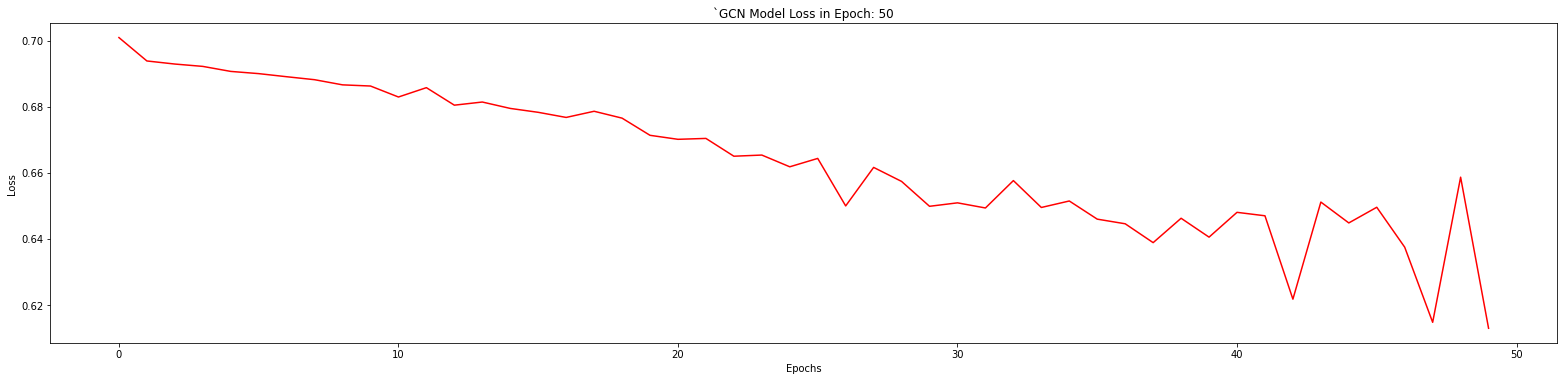

Epoch: 051, ExcitationBP Model Loss: 0.6163
Epoch: 052, ExcitationBP Model Loss: 0.6100
Epoch: 053, ExcitationBP Model Loss: 0.6339
Epoch: 054, ExcitationBP Model Loss: 0.6260
Epoch: 055, ExcitationBP Model Loss: 0.6382
Epoch: 056, ExcitationBP Model Loss: 0.6449
Epoch: 057, ExcitationBP Model Loss: 0.6386
Epoch: 058, ExcitationBP Model Loss: 0.6238
Epoch: 059, ExcitationBP Model Loss: 0.6029
Epoch: 060, ExcitationBP Model Loss: 0.6162
Epoch: 061, ExcitationBP Model Loss: 0.6158
Epoch: 062, ExcitationBP Model Loss: 0.6088
Epoch: 063, ExcitationBP Model Loss: 0.6135
Epoch: 064, ExcitationBP Model Loss: 0.6065
Epoch: 065, ExcitationBP Model Loss: 0.6210
Epoch: 066, ExcitationBP Model Loss: 0.6063
Epoch: 067, ExcitationBP Model Loss: 0.6052
Epoch: 068, ExcitationBP Model Loss: 0.6197
Epoch: 069, ExcitationBP Model Loss: 0.6059
Epoch: 070, ExcitationBP Model Loss: 0.5902
Epoch: 071, ExcitationBP Model Loss: 0.6257
Epoch: 072, ExcitationBP Model Loss: 0.6112
Epoch: 073, ExcitationBP Model L

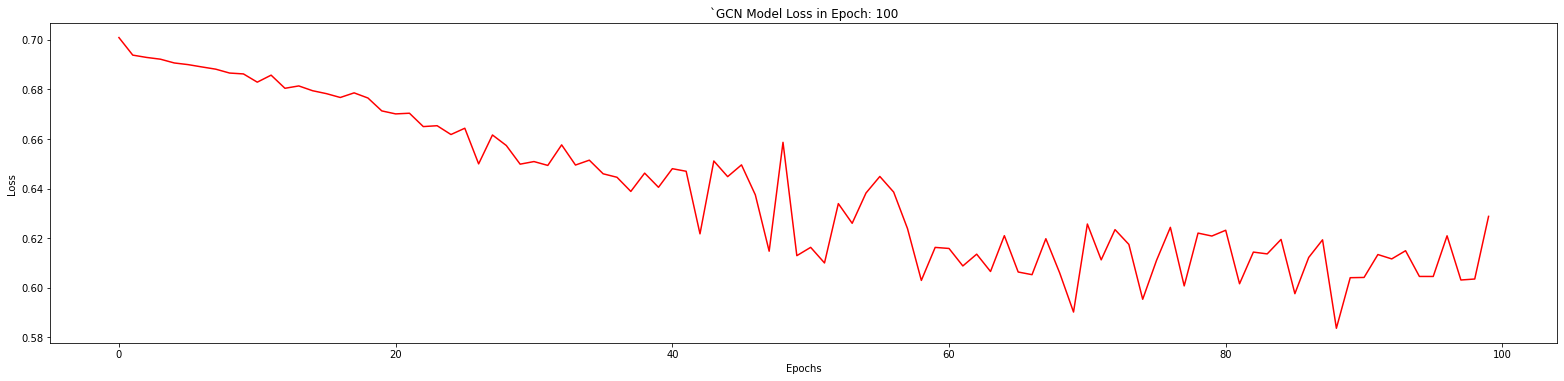

Epoch: 101, ExcitationBP Model Loss: 0.6054
Epoch: 102, ExcitationBP Model Loss: 0.5893
Epoch: 103, ExcitationBP Model Loss: 0.6084
Epoch: 104, ExcitationBP Model Loss: 0.5958
Epoch: 105, ExcitationBP Model Loss: 0.6179
Epoch: 106, ExcitationBP Model Loss: 0.6105
Epoch: 107, ExcitationBP Model Loss: 0.6408
Epoch: 108, ExcitationBP Model Loss: 0.6240
Epoch: 109, ExcitationBP Model Loss: 0.6049
Epoch: 110, ExcitationBP Model Loss: 0.5640
Epoch: 111, ExcitationBP Model Loss: 0.5869
Epoch: 112, ExcitationBP Model Loss: 0.5860
Epoch: 113, ExcitationBP Model Loss: 0.5944
Epoch: 114, ExcitationBP Model Loss: 0.6222
Epoch: 115, ExcitationBP Model Loss: 0.6047
Epoch: 116, ExcitationBP Model Loss: 0.6090
Epoch: 117, ExcitationBP Model Loss: 0.6415
Epoch: 118, ExcitationBP Model Loss: 0.6008
Epoch: 119, ExcitationBP Model Loss: 0.5880
Epoch: 120, ExcitationBP Model Loss: 0.6133
Epoch: 121, ExcitationBP Model Loss: 0.6354
Epoch: 122, ExcitationBP Model Loss: 0.6062
Epoch: 123, ExcitationBP Model L

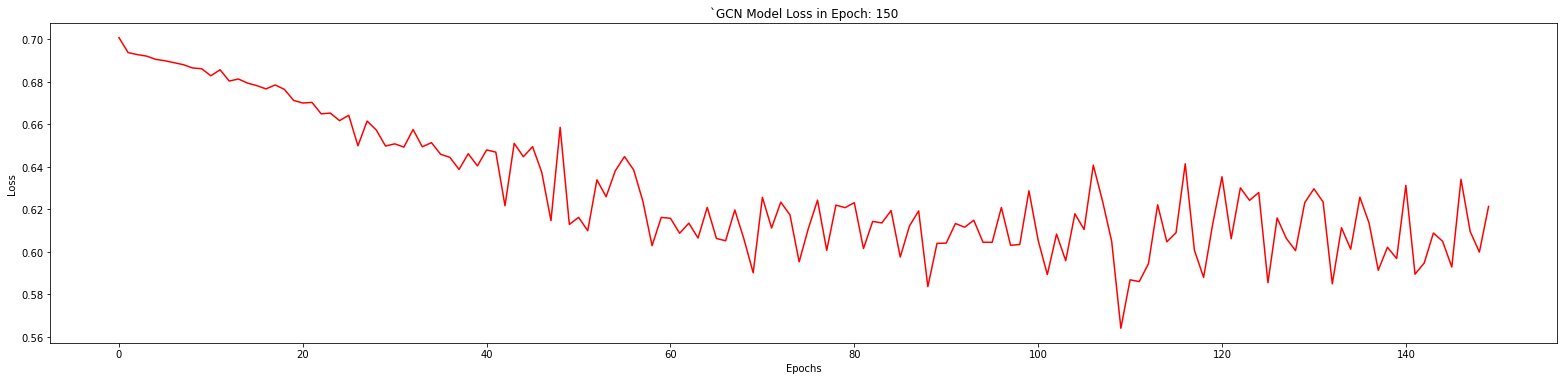

Epoch: 151, ExcitationBP Model Loss: 0.5990
Epoch: 152, ExcitationBP Model Loss: 0.5977
Epoch: 153, ExcitationBP Model Loss: 0.5827
Epoch: 154, ExcitationBP Model Loss: 0.6014
Epoch: 155, ExcitationBP Model Loss: 0.5953
Epoch: 156, ExcitationBP Model Loss: 0.6220
Epoch: 157, ExcitationBP Model Loss: 0.5905
Epoch: 158, ExcitationBP Model Loss: 0.5978
Epoch: 159, ExcitationBP Model Loss: 0.6056
Epoch: 160, ExcitationBP Model Loss: 0.6115
Epoch: 161, ExcitationBP Model Loss: 0.6338
Epoch: 162, ExcitationBP Model Loss: 0.6172
Epoch: 163, ExcitationBP Model Loss: 0.6247
Epoch: 164, ExcitationBP Model Loss: 0.6420
Epoch: 165, ExcitationBP Model Loss: 0.6158
Epoch: 166, ExcitationBP Model Loss: 0.5894
Epoch: 167, ExcitationBP Model Loss: 0.6013
Epoch: 168, ExcitationBP Model Loss: 0.6167
Epoch: 169, ExcitationBP Model Loss: 0.6528
Epoch: 170, ExcitationBP Model Loss: 0.6444
Epoch: 171, ExcitationBP Model Loss: 0.5813
Epoch: 172, ExcitationBP Model Loss: 0.6088
Epoch: 173, ExcitationBP Model L

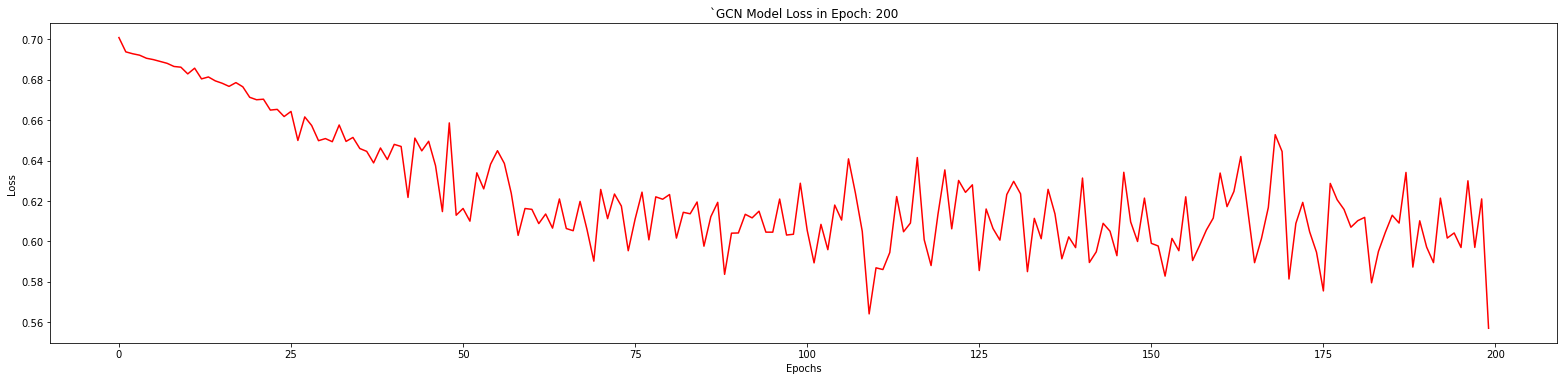

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:

def GCN_Model_test(test_loader):
  predictions = []
  GCN_Model.eval()

  correct = 0
  for batch_of_graphs in test_loader:
    post_conv1_test, post_conv2_test, GCN_gap, GCN_Model_test_out = GCN_Model(batch_of_graphs.x, batch_of_graphs.edge_index, batch_of_graphs.batch)
    GCN_Model_test_pred = GCN_Model_test_out.argmax(dim=1) 
    predictions.append(GCN_Model_test_pred)

    correct += int((GCN_Model_test_pred == batch_of_graphs.y).sum())
      
  return correct / len(test_dataset), predictions[0].detach().tolist()  

In [ ]:
GCN_Model_test_acc, predictions = GCN_Model_test(test_loader)
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.6316


In [ ]:
GCN_Model.eval()

post_conv1, post_conv2, gcn_gap, GCN_Model_test_out  = GCN_Model(dataset[0].x, dataset[0].edge_index, dataset[0].batch)


In [ ]:
print(predictions)
real_labels = []
for graph in test_dataset:
  real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5 0.8157894736842105 0.631578947368421 24


## **Instance Specific Time**

In [ ]:
def instance_time(test_dataset):
  instance_based_time = []
  GCN_Model.eval()
  correct = 0
  for batched_data in test_dataset:
    start_generation = perf_counter()
    post_conv1, post_conv2, out_readout, Grad_CAM_test_out = GCN_Model(batched_data.x, batched_data.edge_index, batched_data.batch)  
    CAM_test_pred = Grad_CAM_test_out.argmax(dim=1)
    consumed_time = perf_counter() - start_generation
    instance_based_time.append(consumed_time)    
  return instance_based_time

In [ ]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.007426932999976543, 0.0047608059999788566, 0.001199458999963099, 0.009165661999986696, 0.001510629000051722, 0.0009466490000136218, 0.001241108999977314, 0.000894359000028544, 0.0009577490000083344, 0.0014714090000325086, 0.0012242690000334733, 0.0011348790000056397, 0.0011187990000394166, 0.001061418999995567, 0.0011340690000452014, 0.0011188689999812595, 0.0010683589999871401, 0.001068148999991081, 0.0010950989999969352, 0.0011219090000054166, 0.0011549890000424057, 0.0010766489999696205, 0.0017733089999865115, 0.001270637999994051, 0.001216508000027261, 0.002781228000003466, 0.002189667999971334, 0.00367130699999052, 0.005085235000024113, 0.002669176999972933, 0.0012250689999859787, 0.0035558570000375767, 0.0017491379999796663, 0.001228627999978471, 0.0013916589999780626, 0.0011488690000192037, 0.0010950590000220473, 0.0010997790000146779]


## **Excitation Back Propagation**

In [ ]:
GCN_Model_state = GCN_Model.state_dict()
print(GCN_Model_state.keys())

odict_keys(['gconv1.weight', 'gconv1.lin.weight', 'gconv2.weight', 'gconv2.lin.weight', 'ffn.weight'])


In [ ]:
print(GCN_Model.gconv1.weight.detach().clone().shape)

torch.Size([7, 7])


In [ ]:
def GCN_Model_EB(test_dataset):
  FFN_activations = []
  GConv2_activations = [] 
  GConv1_activations = [] 

  GCN_Model.eval()

  for batch_of_graphs in test_dataset:
    post_conv1_test_activations, post_conv2_test_activations, GCN_GAP, GCN_Model_test_activations = GCN_Model(batch_of_graphs.x, batch_of_graphs.edge_index, batch_of_graphs.batch)
    GConv1_activations.append(post_conv1_test_activations.detach().tolist())
    GConv2_activations.append(post_conv2_test_activations.detach().tolist())
    FFN_activations.append(GCN_Model_test_activations.detach().tolist())  
    
  return GConv1_activations, GConv2_activations, FFN_activations

# **Activations**

In [ ]:
GConv1_activations, GConv2_activations, FFN_activations = GCN_Model_EB(test_dataset)
print(len(FFN_activations[0]))
#print(FFN_activations)
print(len(GConv1_activations[0]))
print(len(GConv2_activations[0]))
print(len(FFN_activations))

1
17
17
38


In [ ]:
print(np.shape(FFN_activations))
print(np.shape(GConv2_activations), len(GConv2_activations[0]), len(GConv2_activations[0][0]))
print(np.shape(GConv1_activations), len(GConv1_activations[0]), len(GConv1_activations[0][0]))

(38, 1, 2)
(38,) 17 7
(38,) 17 7


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
print(len(GConv1_activations))
print(len(GConv1_activations[0]))

38
17


# **Weights**

In [ ]:
def accumulate_weights(model_for_you):

  #gconv1_bias = model_for_you.gconv1.bias.detach().tolist()
  gconv1_weight = model_for_you.gconv1.weight.detach().tolist()

  #gconv2_bias = model_for_you.gconv2.bias.detach().tolist()
  gconv2_weight = model_for_you.gconv2.weight.detach().tolist()

  #ffn_bias = model_for_you.ffn.bias.detach().tolist()
  ffn_weight = model_for_you.ffn.weight.detach().tolist()

  

  #return gconv1_weight, gconv1_bias, gconv2_weight, gconv2_bias, ffn_weight, ffn_bias
  return gconv1_weight, gconv2_weight, ffn_weight

In [ ]:
GConv1_weight, GConv2_weight, FFN_weight = accumulate_weights(GCN_Model)

In [ ]:
print(np.shape(FFN_weight))
print(np.shape(GConv2_weight))
print(np.shape(GConv1_weight))

(2, 7)
(7, 7)
(7, 7)


# **Transposed Weights**

In [ ]:
GConv1_weight_T = np.array(GConv1_weight).transpose()
GConv1_weight_T = GConv1_weight_T.tolist()
print(np.shape(GConv1_weight_T))

(7, 7)


In [ ]:
GConv2_weight_T = np.array(GConv2_weight).transpose()
GConv2_weight_T = GConv2_weight_T.tolist()
print(np.shape(GConv2_weight_T))

(7, 7)


In [ ]:
FFN_weight_T = np.array(FFN_weight).transpose()
FFN_weight_T = FFN_weight_T.tolist()
print(np.shape(FFN_weight_T))

(7, 2)


In [ ]:
GConv1_weight = GConv1_weight.copy()
GConv2_weight = GConv2_weight.copy()
FFN_weight = FFN_weight.copy()

In [ ]:
a = np.array([[1., 2.], [3., 4.], [5, 6]])
print(a)


b=a[::-1]
print(b)


[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[5. 6.]
 [3. 4.]
 [1. 2.]]


In [ ]:
def my_relu(input):
  return np.maximum(0, input)
print(my_relu([0,1,2,3,4,-1,-2,-4,-6]))
print(my_relu(-1))

[0 1 2 3 4 0 0 0 0]
0


In [ ]:
def normalize_labels_to_probabilistics(labels):
  labels = torch.tensor(labels)
  logits = F.log_softmax(labels, dim=1)
  prob = F.softmax(logits, dim=1)
  prob = prob.detach().tolist()
  norms = prob[0]
  #print(norms)
  return norms

In [ ]:
def Compute_P_last_layer(FFN_activations, wrt):
  prob = normalize_labels_to_probabilistics(FFN_activations)
  
  if wrt == 2:
    last_layer_R_k = [0] * len(prob)
    last_layer_R_k[prob.index(max(prob))] = max(prob)#1
    return last_layer_R_k

  elif wrt == 1:
    last_layer_R_k = [0] * len(prob)
    last_layer_R_k[1] = 1#prob[1]
    return last_layer_R_k

  elif wrt == 0:
    last_layer_R_k = [0] * len(prob)
    last_layer_R_k[0] = 1#prob[0]
    return last_layer_R_k

In [ ]:
def Division_by_Zero(epsilon, act_hat):
  for i in range(len(act_hat)):
    for j in range(len(act_hat[i])):
      if act_hat[i][j] == 0:
        act_hat[i][j] = act_hat[i][j] + epsilon
      else:
        act_hat[i][j] = act_hat[i][j]
  return act_hat

In [ ]:

def Compute_Pobabilities(last_layer, epsilon, preceding_layer_activations, exceding_layer_weights, exceding_layer_prob):


  # 1 Weights and Activations
  weights_and_activations_Graph = []
  for i in range(len(exceding_layer_weights)):
    weights_and_activations_Node = []
    for j in range(len(preceding_layer_activations)):
      weights_and_activations_Node.append(sum(np.multiply(my_relu(exceding_layer_weights[i]), preceding_layer_activations[j])))
    weights_and_activations_Graph.append(weights_and_activations_Node)
  #print(np.shape(weights_and_activations_Graph), weights_and_activations_Graph)
  #print("1 Multiplication of Weights and Activations: ", np.shape(weights_and_activations_Graph))
  weights_and_activations_Graph = Division_by_Zero(epsilon, weights_and_activations_Graph)
  weights_and_activations_Graph = np.array(weights_and_activations_Graph).transpose()
  weights_and_activations_Graph = weights_and_activations_Graph.tolist()
  #print("mul: ",np.shape(weights_and_activations_Graph), weights_and_activations_Graph)
  # 2 Point-Wise division
  #print(exceding_layer_prob)
  if last_layer:
    division_result_Graph = []
    for i in range(len(exceding_layer_prob)):
      division_result = [float(exceding_layer_prob[i]/ weights_and_activations_Graph[j][i]) for j in range(len(weights_and_activations_Graph))]
      division_result_Graph.append(division_result)
    #print("2 Division Results: ", np.shape(division_result_Graph))
    division_result_Graph = np.array(division_result_Graph).transpose()
    division_result_Graph = division_result_Graph.tolist()
    #print(np.shape(division_result_Graph), division_result_Graph)
  else:
    division_result_Graph = []
    for i in range(len(exceding_layer_prob)):
      division_result = [float(exceding_layer_prob[i][j]/ weights_and_activations_Graph[i][j]) for j in range(len(weights_and_activations_Graph[i]))]
      division_result_Graph.append(division_result)
    #print("2 Division Results: ", np.shape(division_result_Graph))
    #print(np.shape(division_result_Graph), division_result_Graph)

  # 3 Multiplication by Weights
  exceding_layer_weights = np.array(exceding_layer_weights).transpose()
  exceding_layer_weights = exceding_layer_weights.tolist()

  weights_third_step_Graph = []
  for i in range(len(division_result_Graph)):
    weights_third_step = []
    for j in range(len(exceding_layer_weights)):
      weights_third_step.append(sum([x*y for x,y in zip(my_relu(exceding_layer_weights[j]), division_result_Graph[i])]))
    weights_third_step_Graph.append(weights_third_step)
  #print("3 Third Step: ", np.shape(weights_third_step_Graph))
  #print(weights_third_step_Graph)

  # 4 Forth Step
  final_probability_Graph = []
  for i in range(len(preceding_layer_activations)):
    final_probability_vector = [preceding_layer_activations[i][j] * weights_third_step_Graph[i][j] for j in range(len(preceding_layer_activations[i]))]
    final_probability_Graph.append(final_probability_vector)
  #print(np.shape(final_probability_Graph))
  #print(final_probability_Graph)


  
  return final_probability_Graph

In [ ]:
def One_Graph_EB(wrt, epsilon, input_sample, weights, activations):
  GConv1_weight = weights[0]
  GConv1_weight_T = weights[1]

  GConv2_weight = weights[2]
  GConv2_weight_T = weights[3]

  FFN_weight = weights[4]
  FFN_weight_T = weights[5]

  GConv1_activations = activations[0]
  GConv2_activations = activations[1]
  FFN_activations = activations[2]


  #print(FFN_activations)
  last_layer_prob = Compute_P_last_layer(FFN_activations, wrt)
  #print("FFN: ", last_layer_prob)

  hidden2_probability_vector = Compute_Pobabilities(True, epsilon, GConv2_activations, FFN_weight, last_layer_prob)
  #print("Second GCN Probability: ",hidden2_probability_vector)
  #print("hid2: ", np.shape(hidden2_probability_vector)) 

  hidden1_probability_vector = Compute_Pobabilities(False, epsilon, GConv1_activations, GConv2_weight_T, hidden2_probability_vector)
  #print("First GCN Probability: ",hidden2_probability_vector)
  #print("hid1: ", np.shape(hidden1_probability_vector))
  


  input_probability_vector = Compute_Pobabilities(False, epsilon, input_sample, GConv1_weight_T, hidden1_probability_vector)
  #print("Input Probability: ",input_probability_vector)
  #print("input: ", np.shape(input_probability_vector))
  
  
  return input_probability_vector

In [ ]:
print(np.shape(GConv1_weight), np.shape(GConv2_weight), np.shape(FFN_weight_T))
print(np.shape(GConv1_weight_T), np.shape(GConv2_weight_T), np.shape(FFN_weight))

(7, 7) (7, 7) (7, 2)
(7, 7) (7, 7) (2, 7)


In [ ]:
print(np.shape(dataset[0].x.detach().tolist()))

(17, 7)


In [ ]:
print(np.shape(dataset[0].x[0]), np.shape(GConv1_activations), np.shape(GConv2_activations), np.shape(FFN_activations))

torch.Size([7]) (38,) (38,) (38, 1, 2)


In [ ]:
print(len(test_dataset[0].x))
print(test_dataset[0])

17
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [ ]:
i = 0
epsilon = 1e-16
wrt = 0
EB = One_Graph_EB(wrt, epsilon, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]])
print(EB)

[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.9733191493265737, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.9733191493265737, 0.0, 0.0, 0.0, 0.0]]


## **MWP for all test graphs**

In [ ]:
def Get_ExcitationBPs(dataset, wrt):
  EBs_Testset = []
  epsilon = 1e-16
  #wrt = 0
  for i in range(len(dataset)):
    EBs_Graph = One_Graph_EB(wrt, epsilon, dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]])
    graphs = []
    for j in range(len(EBs_Graph)):
      graphs.append(sum(EBs_Graph[j]))
    norm = [(float(i))/(max(graphs) - min(graphs) + 1e-16) for i in graphs] 
    EBs_Testset.append(norm)

  return EBs_Testset
  #print(i)
  #print(x)
  #print(test_dataset[i].y)

## **Fidelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    post_conv1, post_conv2, gcn_gap, out = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(out, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc

In [ ]:
def is_salient(score, importance_range):
  start = importance_range[0]
  end = importance_range[1]
  #print(start, score, end)
  if float(start) <= float(score) <= float(end):
    return True
  else:
    return False

In [ ]:
def drop_important_nodes(your_dataset, importance_range, wrt):
  EBP_attribution_scores = Get_ExcitationBPs(your_dataset, wrt)
  occluded_GNNgraph_list = []
  #print(np.shape(EBP_attribution_scores[0]))
  for i in range(len(EBP_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((EBP_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, 2)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [ ]:
def binarize_scores(dataset, wrt, importance_range):
  EBPs_attribution_scores = Get_ExcitationBPs(dataset, wrt)
  binarized_attribution_scores_list = []
  for scores in EBPs_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [ ]:
def compute_contrastivity(dataset, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)

## **Sparsity**

In [ ]:
def binarize_nodes(dataset, importance_range):
  binarized_salient_nodes_for_graph = binarize_scores(dataset, 2, importance_range)
  binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_range)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_preds = []
  
  for i in range(len(binarized_salient_nodes_for_class0)):
      class_0_graph = []
      for j in range(len(binarized_salient_nodes_for_class0[i])):
        if is_salient((binarized_salient_nodes_for_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(binarized_salient_nodes_for_class1)):
      class_1_graph = []
      for j in range(len(binarized_salient_nodes_for_class1[i])):
        if is_salient((binarized_salient_nodes_for_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(binarized_salient_nodes_for_graph)):
      class_graph = []
      for j in range(len(binarized_salient_nodes_for_graph[i])):
        if is_salient((binarized_salient_nodes_for_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_preds.append(class_graph)

  return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [ ]:
def compute_sparsity(dataset, importance_range):
  salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(dataset, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_preds)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_preds) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

In [ ]:
def go_to_evaluations(your_model, dataset, importance_range):
  start_generation = perf_counter()
  norm_lrps = EBPs_attribution_scores = Get_ExcitationBPs(dataset, 2)
  time_consumption = perf_counter() - start_generation

  fid_EBP_label = Fidelity(your_model, dataset, importance_range)

  contrastivity_with_EBP = compute_contrastivity(dataset, importance_range)

  sparsity_with_EBP = compute_sparsity(dataset, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
  #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
  #  wr.writerow([str(Explainability_name), "MUTAG", fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption])
  task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, ExcitationBP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption, mean(ExcitationBP_Model_training_time_per_epoch), times])
  #return fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption

In [ ]:
#fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption = go_to_evaluations(GCN_Model, test_dataset, [0.5, 1])
#print(fid_EBP_label, contrastivity_with_EBP, sparsity_with_EBP, time_consumption)
go_to_evaluations(GCN_Model, test_dataset, [0.5, 1])

In [ ]:
def MWP_Graph_Features(EB, sample):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for sample: " + str(sample) + "where the GNN is trained on " + str(EPOCHS) + " Epochs")
  
  ax1.plot(EB, color='r')
  print('done')
  
  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Marginal Winning Probability generated for sample number: " + str(sample) + ".png")
  plt.show()

(7,)
done


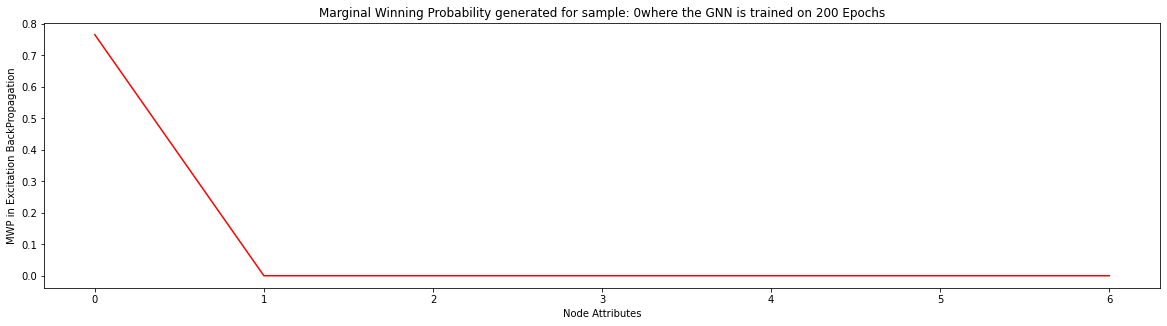

In [ ]:
Averaged_EB_one_graph = np.mean(EB, axis=0)
print(np.shape(Averaged_EB_one_graph))
MWP_Graph_Features(Averaged_EB_one_graph, 0)

## **Class based averaging on MWP**

In [ ]:
Graph_Index_Class1 = []
Graph_Index_Class2 = []

In [ ]:
for i in range(len(test_dataset)):
  if test_dataset[i].y == 0:
    Graph_Index_Class1.append(i)
  else:
    Graph_Index_Class2.append(i)

In [ ]:
print(len(Graph_Index_Class1), len(Graph_Index_Class2))
print(Graph_Index_Class1)
print(Graph_Index_Class2)

24 33
[4, 5, 6, 7, 12, 16, 21, 25, 26, 28, 29, 30, 31, 33, 36, 37, 39, 42, 50, 52, 53, 54, 55, 56]
[0, 1, 2, 3, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 27, 32, 34, 35, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51]


In [ ]:
EBs_Class1 = []
EBs_Class2 = []

## **MWPs of Graphs in each Class**

In [ ]:
for index in Graph_Index_Class1:
  EBs_Class1.append(EBs_Testset[index])
for index in Graph_Index_Class2:
  EBs_Class2.append(EBs_Testset[index])

In [ ]:
print(EBs_Class1)
print(EBs_Class2)
print(len(EBs_Class1))
print(len(EBs_Class2))
print(np.shape(EBs_Class1[0]))
print(np.shape(EBs_Class2[0]))

[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.

## **Averaged MWPs on Node Features in all Graphs**

In [ ]:
EBs_Class1_Averaged_intra_Graph = []
EBs_Class2_Averaged_intra_Graph = []
for graph in EBs_Class1:
  EBs_Class1_Averaged_intra_Graph.append(np.mean(graph, axis=0).tolist())

for graph in EBs_Class2:
  EBs_Class2_Averaged_intra_Graph.append(np.mean(graph, axis=0).tolist())

In [ ]:
print(EBs_Class1_Averaged_intra_Graph)
print(EBs_Class2_Averaged_intra_Graph)
print(len(EBs_Class1_Averaged_intra_Graph))
print(len(EBs_Class2_Averaged_intra_Graph))
print(np.shape(EBs_Class1_Averaged_intra_Graph))
print(np.shape(EBs_Class2_Averaged_intra_Graph))

[[0.6470588235294118, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.45454545454545453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.27272727272727276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.08333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5789473684210527, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19047619047619047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5384615384615384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07692307692307694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.3636363636363637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.18181818181818185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0, 0

## **Averaged MWPs on Graphs in each Class**

In [ ]:
EBs_Class1_Averaged_intra_Class_Graphs = []
EBs_Class2_Averaged_intra_Class_Graphs = []
EBs_Class1_Averaged_intra_Class_Graphs = np.mean(EBs_Class1_Averaged_intra_Graph, axis=0)
EBs_Class2_Averaged_intra_Class_Graphs = np.mean(EBs_Class2_Averaged_intra_Graph, axis=0)

In [ ]:
print(EBs_Class1_Averaged_intra_Class_Graphs)

[0.21172313 0.         0.         0.         0.         0.
 0.        ]


## **PLOT Class-Wise Averaged MWPs **

In [ ]:
def Averaged_EBs_Intra_Classes(EB):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Avg Graphs' MWPs")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for Class: One, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Avg Graphs' MWPs")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for Class: Two, where the GNN is trained on " + str(EPOCHS) + " Epochs") 

  ax1.plot(EB[0], color='r')
  ax2.plot(EB[1], color='r') 

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Dimensionally Averaged Excitations for Classes.png")
  plt.show()

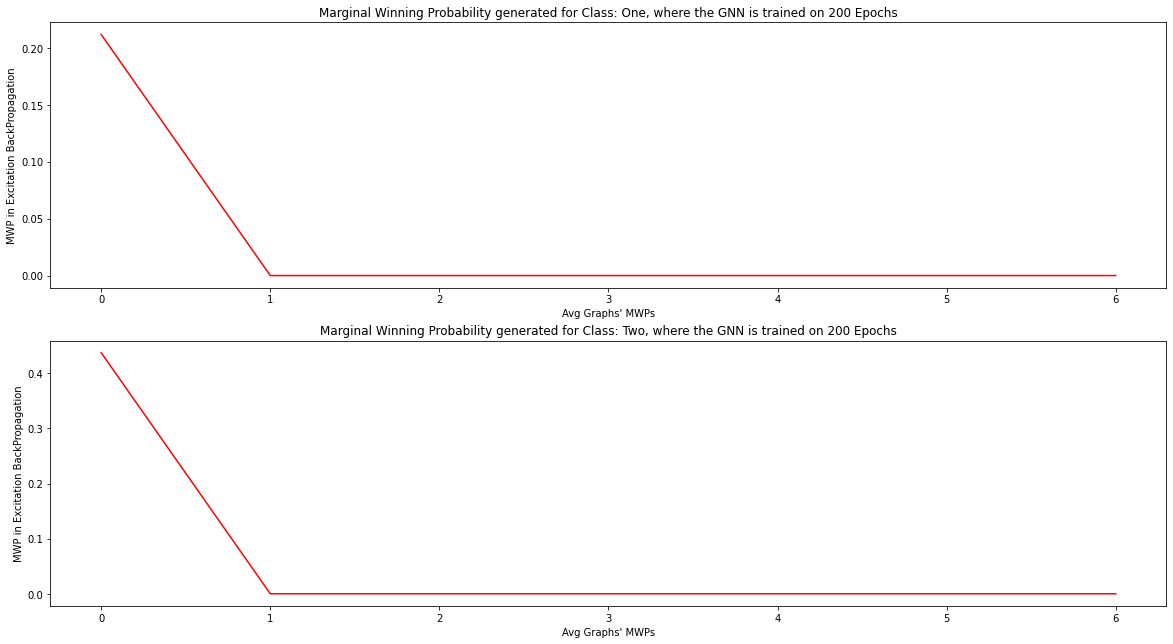

In [ ]:
Averaged_EBs_Intra_Classes([EBs_Class1_Averaged_intra_Class_Graphs, EBs_Class2_Averaged_intra_Class_Graphs])